# Quasi-Newton methods: BFGS
La caratteristica principale del metodo BFGS è la sua capacità di approssimare la matrice inversa della hessiana, una matrice che descrive la curvatura della funzione obiettivo, senza richiedere il calcolo esplicito della hessiana stessa. Ciò lo rende computazionalmente efficiente, in quanto evita la necessità di calcolare e invertire la hessiana durante ogni iterazione.

Il nome "quasi-Newton" deriva dal fatto che il metodo BFGS appartiene alla categoria più ampia dei metodi quasi-Newtoniani, che sono progettati per approssimare l'inversa della hessiana senza calcolarla direttamente.

In breve, il metodo BFGS è utilizzato per **risolvere problemi di ottimizzazione iterativamente**, cercando di trovare il **punto in cui la derivata della funzione obiettivo è zero (il minimo o il massimo)**. 

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.optimize
import scipy as sp
import matplotlib.pyplot as plt

# We enable double precision in JAX
from jax.config import config
config.update("jax_enable_x64", True)

C:\Users\luigi\AppData\Local\Temp\ipykernel_16424\1989467522.py:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


Consider the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), that is minimized in $\mathbf{x} = (1,1,\dots,1)^T$:

$$\mathcal{L}(\mathbf{x}) = \sum_{i=1}^{N-1} [100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2]$$

In [4]:
def loss(x):
    return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

Use `jax` to compute and compile the Rosenbrock function and its gradient.

In [5]:
grad = jax.grad(loss)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

In [6]:
N = 100
x = np.random.rand(N)*2

%timeit loss(x)
%timeit loss_jit(x)
%timeit grad(x)
%timeit grad_jit(x)

21.7 µs ± 779 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
25.7 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
250 ms ± 9.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.7 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Apply BFGS

BFGS descrive la curvatura della funzione obiettivo. La curvatura descrive come la funzione si "piega" o "curva" in prossimità di quel punto specifico.

Nel contesto dell'ottimizzazione, la curvatura è spesso associata alla hessiana della funzione obiettivo. La hessiana è una matrice delle seconde derivate parziali della funzione rispetto alle variabili indipendenti. In un punto stazionario, dove il gradiente (prima derivata) della funzione è zero, la hessiana può essere utilizzata per determinare la curvatura della superficie della funzione in quel punto.

- Se tutti gli autovalori della hessiana sono positivi, la funzione è localmente convessa, e il punto è un minimo.
- Se tutti gli autovalori sono negativi, la funzione è localmente concava, e il punto è un massimo.
- Se ci sono autovalori positivi e negativi, la curvatura è mista, e il punto è un punto di sella.

In ottimizzazione numerica, comprendere la curvatura della funzione obiettivo è importante per scegliere adeguate strategie di ottimizzazione. Ad esempio, metodi come il metodo di Newton utilizzano informazioni sulla curvatura attraverso la hessiana per determinare la direzione di discesa ottimale. Nel caso di algoritmi quasi-Newton, come il BFGS, si approssima la hessiana inversa per adattarsi alla curvatura della funzione senza dover calcolare esplicitamente la hessiana stessa.

epochs: 528
error: 1.464e-12


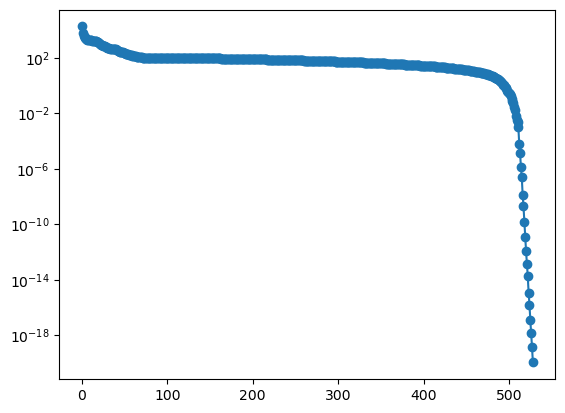

In [7]:
N = 100
max_epochs = 1000
tol = 1e-8

np.random.seed(0)
x_guess = np.random.rand(N)*2

epoch = 0
grad = grad_jit(x_guess)
I = np.eye(N)
Binv = I
x = x_guess
history = [loss_jit(x_guess)]

while np.linalg.norm(grad) > tol and epoch < max_epochs:
    epoch += 1
    # search direction
    p = - Binv @ grad
    
    # line search
    line_search = sp.optimize.line_search(loss_jit, grad_jit, x, p)
    alpha = line_search[0]
    x_new = x + alpha * p

    # computing y and s
    s = x_new - x
    x = x_new
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    grad = grad_new

    # Sherman–Morrison update
    rho = 1.0 / (np.dot(y, s))
    E = I - rho * np.outer(y, s)
    Binv = E.T @ Binv @ E + rho * np.outer(s, s)

    history.append(loss_jit(x))

x_ex = np.ones(N)
err = x - x_ex

print('epochs: %d' % epoch)
print('error: %1.3e' % (np.linalg.norm(err) / np.linalg.norm(x_ex)))
plt.semilogy(history, 'o-')